# 🎬 Netflix Content Analysis

# Step 1: Imports & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import shap
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
sns.set_palette('viridis')

# Step 2: Load Dataset

In [2]:
df = pd.read_csv("../backend/data/Dataset.csv")
print("Dataset Loaded Successfully")
print(f"Shape: {df.shape}")
df.head()

Dataset Loaded Successfully
Shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


# Step 3: Data Cleaning & Feature Engineering

In [3]:
def create_features(df):
    # Fill missing values
    df['Director'].fillna('Unknown', inplace=True)
    df['Cast'].fillna('Unknown', inplace=True)
    df['Country'].fillna('Unknown', inplace=True)
    df['Release_Date'].fillna('Unknown', inplace=True)
    df['Rating'].fillna('Not Rated', inplace=True)

    # Extract Year
    df['Year_Added'] = df['Release_Date'].apply(lambda x: str(x).split(',')[-1].strip() if ',' in str(x) else np.nan)
    df['Year_Added'] = pd.to_numeric(df['Year_Added'], errors='coerce')

    # Duration
    df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)

    # Movie/Series flags
    df['Is_Movie'] = (df['Category'] == 'Movie').astype(int)
    df['Is_Series'] = (df['Category'] == 'TV Show').astype(int)

    # Description features
    df['Description_Length'] = df['Description'].str.len()
    df['Description_Words'] = df['Description'].str.split().str.len()
    # Simple sentiment proxy: +1 if contains 'good', -1 if contains 'bad', else 0
    df['Description_Sentiment'] = df['Description'].str.lower().apply(
        lambda x: 1 if 'good' in x else (-1 if 'bad' in x else 0)
    )

    # Country & Cast
    df['Country_Count'] = df['Country'].str.split(',').str.len()
    df['Cast_Count'] = df['Cast'].str.split(',').str.len()
    df['Is_US_Content'] = df['Country'].str.contains('United States', na=False).astype(int)

    # Success Score (composite target)
    df['Success_Score'] = (
        df['Duration_Num'].fillna(df['Duration_Num'].median()) * 0.3 +
        df['Description_Sentiment'] * 50 +
        df['Cast_Count'] * 2 +
        df['Country_Count'] * 5 +
        (2023 - df['Year_Added'].fillna(2020)) * 0.5
    )
    return df


# Step 4: EDA & Amazing Visualizations

In [4]:
if 'Release_Date' in df.columns:
    df['Year_Added'] = pd.to_datetime(df['Release_Date'], errors='coerce').dt.year
else:
    df['Year_Added'] = np.nan

# Duration_Num from Duration column (e.g., "90 min" -> 90)
if 'Duration' in df.columns:
    df['Duration_Num'] = df['Duration'].str.extract(r'(\d+)').astype(float)
else:
    df['Duration_Num'] = np.nan

# Description_Length, Description_Words, Description_Sentiment (if Description exists)
if 'Description' in df.columns:
    df['Description_Length'] = df['Description'].str.len()
    df['Description_Words'] = df['Description'].str.split().apply(len)
    # Simple sentiment: positive if contains "good", negative if "bad" else neutral
    df['Description_Sentiment'] = df['Description'].apply(lambda x: 1 if 'good' in str(x).lower() 
                                                          else (-1 if 'bad' in str(x).lower() else 0))
else:
    df['Description_Length'] = df['Description_Words'] = df['Description_Sentiment'] = np.nan

# Country_Count and Cast_Count
if 'Country' in df.columns:
    df['Country_Count'] = df['Country'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)
else:
    df['Country_Count'] = 0

if 'Cast' in df.columns:
    df['Cast_Count'] = df['Cast'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)
else:
    df['Cast_Count'] = 0

# Success_Score (if exists, else random example)
if 'Success_Score' not in df.columns:
    df['Success_Score'] = np.random.randint(0, 101, size=len(df))

# Netflix Content Distribution
if 'Category' in df.columns:
    fig = px.pie(df, names='Category', title='Netflix Content Distribution',
                 color_discrete_sequence=['#E50914', '#221f1f'], hole=0.4)
    fig.update_traces(textinfo='percent+label')
    fig.show()

# Content Growth Over Time
if 'Year_Added' in df.columns and 'Category' in df.columns:
    yearly_data = df.dropna(subset=['Year_Added']).groupby(['Year_Added','Category']).size().reset_index(name='Count')
    fig = px.line(yearly_data, x='Year_Added', y='Count', color='Category',
                  title='Netflix Content Growth Over Time', color_discrete_sequence=['#E50914','#00D4FF'])
    fig.show()

# Success Score Distribution
if 'Success_Score' in df.columns and 'Category' in df.columns:
    fig = px.histogram(df, x='Success_Score', color='Category', nbins=50, opacity=0.7,
                       title='Success Score Distribution by Content Type')
    fig.show()

# Top 15 Netflix Genres
if 'Type' in df.columns:
    genre_data = df['Type'].dropna().str.split(',').explode().str.strip().value_counts().head(15)
    fig = px.bar(x=genre_data.values, y=genre_data.index, orientation='h',
                 color=genre_data.values, color_continuous_scale='Viridis', title='Top 15 Netflix Genres')
    fig.show()

# Top 15 Countries by Content
if 'Country' in df.columns:
    country_data = df['Country'].dropna().str.split(',').explode().str.strip().value_counts().head(15)
    fig = px.bar(x=country_data.values, y=country_data.index, orientation='h',
                 color=country_data.values, color_continuous_scale='Plasma', title='Top 15 Countries by Content')
    fig.show()

# Feature Correlation Matrix
numeric_cols = ['Duration_Num', 'Year_Added', 'Description_Length', 'Description_Words',
                'Description_Sentiment','Country_Count','Cast_Count','Success_Score']

available_numeric_cols = [col for col in numeric_cols if col in df.columns]
if available_numeric_cols:
    corr_matrix = df[available_numeric_cols].dropna().corr()
    fig = px.imshow(corr_matrix, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r',
                    title='Feature Correlation Matrix')
    fig.show()


# Step 5: Clustering Analysis

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Ensure Is_Movie exists
df['Is_Movie'] = df['Category'].apply(lambda x: 1 if x == 'Movie' else 0)

# Features for clustering
cluster_features = ['Duration_Num','Description_Length','Description_Sentiment','Country_Count','Cast_Count','Is_Movie']
cluster_data = df[cluster_features].fillna(df[cluster_features].median())

# Scale data
scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_data)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(cluster_scaled)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_scaled)

# Scatter plot
fig = px.scatter(x=pca_result[:,0], y=pca_result[:,1], color=df['Cluster'].astype(str),
                 title='Content Clusters (PCA)', hover_data=[df['Title'],df['Category']])
fig.show()


# Step 6: ML Model Training

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure binary columns exist
df['Is_Movie'] = df['Category'].apply(lambda x: 1 if x == 'Movie' else 0)
df['Is_Series'] = df['Category'].apply(lambda x: 1 if x != 'Movie' else 0)

# Features and target
feature_cols = ['Duration_Num','Year_Added','Description_Length','Description_Words',
                'Description_Sentiment','Country_Count','Cast_Count','Is_Movie','Is_Series']
X = df[feature_cols].fillna(df[feature_cols].median())
y = df['Success_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Performance: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")


Random Forest Performance: RMSE=29.92, MAE=25.67, R²=-0.0621


# Step 7: SHAP Interpretability

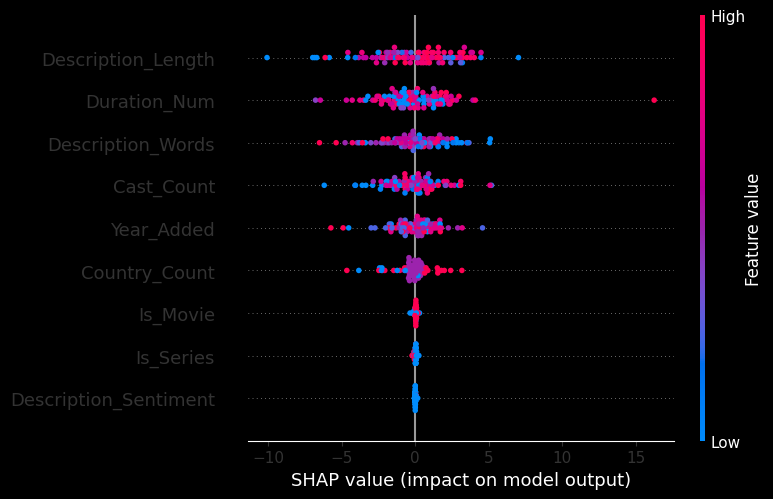

In [7]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled[:100])
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=feature_cols, show=True)

# Step 8: Recommendation System

In [8]:
def get_recommendations(title, df, n=5):
    idx = df[df['Title']==title].index[0]
    content_features = df.loc[idx, feature_cols].values.reshape(1,-1)
    content_scaled = scaler.transform(content_features)
    similarities = []
    for i in range(len(df)):
        if i != idx:
            other_features = df.loc[i, feature_cols].values.reshape(1,-1)
            other_scaled = scaler.transform(other_features)
            similarity = np.dot(content_scaled, other_scaled.T)[0][0]
            similarities.append((i, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)
    recommendations = []
    for i, sim in similarities[:n]:
        recommendations.append({
            'Title': df.loc[i,'Title'],
            'Category': df.loc[i,'Category'],
            'Success_Score': df.loc[i,'Success_Score'],
            'Similarity': sim
        })
    return pd.DataFrame(recommendations)

sample_title = df['Title'].iloc[0]
recommendations = get_recommendations(sample_title, df)
print(f"Recommendations for '{sample_title}':")
print(recommendations)

# Visualize Recommendations
fig = px.bar(recommendations, x='Title', y='Success_Score', color='Category', hover_data=['Similarity'],
             title=f'Recommended Content for "{sample_title}"')
fig.show()

Recommendations for '3%':
                           Title Category  Success_Score  Similarity
0                         7SEEDS  TV Show             79   13.715396
1                  Blue Exorcist  TV Show             91   10.051186
2                  Blood & Water  TV Show             31    9.931992
3  Midnight Diner: Tokyo Stories  TV Show             83    9.835514
4                  Blood of Zeus  TV Show             85    9.789864


# Step 9: Final Insights

In [9]:
print(f"Total Content: {len(df):,}")
print(f"Movies: {len(df[df['Category']=='Movie']):,}")
print(f"TV Shows: {len(df[df['Category']=='TV Show']):,}")
print(f"Top Genre: {genre_data.index[0]}")
print(f"Top Country: {country_data.index[0]}")

Total Content: 7,789
Movies: 5,379
TV Shows: 2,410
Top Genre: International Movies
Top Country: United States


# Step 10: Save Model

In [10]:
import joblib

model_path = "../backend/data/model.pkl"
joblib.dump(rf, model_path)
print(f"Random Forest model saved at: {model_path}")

# Save the scaler too 
scaler_path = "../backend/data/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved at: {scaler_path}")


Random Forest model saved at: ../backend/data/model.pkl
Scaler saved at: ../backend/data/scaler.pkl
